In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

#filename = maybe_download('text8.zip', 31344016)
filename = maybe_download('text8_small.zip', 9403323)

Found and verified text8_small.zip


In [3]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

In [4]:
# Step 2: Build the dictionary and replace rare words with UNK token.
#vocabulary_size = 50000
vocabulary_size = 5000
def build_dataset(words):
    count = [['UNK', -1]]#Eventually count[0][1] will hold the value of total count of words "UNK" is dummy key
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    printStrCnt=0
    printStr=""
    for word, _ in count:
        dictionary[word] = len(dictionary)
        if printStrCnt<5:
            printStr+= word+":"+str(len(dictionary))+" "
            printStrCnt+=1
    print("Built Dictionary ~>", printStr)
    data = list()#data will hold index of all words in the dictionary s.t. len(data)=len(words)
    unk_count = 0
    for word in words:
        if word in dictionary:#Is it one of the words featured in top vocabulary_size!
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
        unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

In [5]:
print(filename)
words = read_data(filename)
print('Data size', len(words))
print(words[0],words[1])
data, count, dictionary, reverse_dictionary = build_dataset(words)
"""
data: Hold Index of all words in the dictionary
count: Holds List of [Word, Frequency] for all Vocab Words
dictionary: {word:index}
reverse_dictionary:{index:word}
"""
print("len(data)-",len(data),";len(words)",len(words))
sampleDictkeys=list(dictionary.keys())[:5]
sampleReverseDictKeys=list(reverse_dictionary.keys())[:5]
print("Dictionary ~> <KEYS> ",sampleDictkeys," <VALUES> ",[dictionary[key] for key in sampleDictkeys])
print("Reverse Dictionary ~> <KEYS> ",sampleReverseDictKeys," <VALUES> ",[reverse_dictionary[key] for key in sampleReverseDictKeys])
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
data_index = 0

text8_small.zip
Data size 1604152
anarchism originated
Built Dictionary ~> UNK:1 the:2 of:3 one:4 and:5 
len(data)- 1604152 ;len(words) 1604152
Dictionary ~> <KEYS>  ['hebrew', 'reading', 'wooden', 'strait', 'twenty']  <VALUES>  [1095, 1237, 4964, 4299, 1580]
Reverse Dictionary ~> <KEYS>  [0, 1, 2, 3, 4]  <VALUES>  ['UNK', 'the', 'of', 'one', 'and']
Most common words (+UNK) [['UNK', 1604152], ('the', 100788), ('of', 58449), ('one', 42521), ('and', 39818)]
Sample data [1090, 3050, 13, 7, 191, 2, 4194, 48, 61, 139] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [6]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    print("Data is Global" , data[data_index])
    print("data_index is Global ",data_index)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    print("At data_index ",data_index," Current Buffer is : ",buffer)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        print("Skip_window ",skip_window)
        print("At i ",i," Current Buffer is : ",buffer)
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            print("New target =",target, "current targets_to_avoid ",targets_to_avoid)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
            print("i * num_skips + j ", i * num_skips + j, "skip_window ",skip_window,buffer[skip_window],buffer[target])
            print("skip_window=>target ",skip_window,target)
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [7]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
print("Total Batches ",len(batch)," Total Labels ",len(labels))#This is equal to batch_size
#print("Batches ",batch , "labels ",labels)
#for i in range(8):
#    print(batch[i], reverse_dictionary[batch[i]],'->', labels[i, 0], reverse_dictionary[labels[i, 0]])

Data is Global 1090
data_index is Global  0
At data_index  3  Current Buffer is :  deque([1090, 3050, 13], maxlen=3)
Skip_window  1
At i  0  Current Buffer is :  deque([1090, 3050, 13], maxlen=3)
New target = 2 current targets_to_avoid  [1]
i * num_skips + j  0 skip_window  1 3050 13
skip_window=>target  1 2
New target = 0 current targets_to_avoid  [1, 2]
i * num_skips + j  1 skip_window  1 3050 1090
skip_window=>target  1 0
Skip_window  1
At i  1  Current Buffer is :  deque([3050, 13, 7], maxlen=3)
New target = 2 current targets_to_avoid  [1]
i * num_skips + j  2 skip_window  1 13 7
skip_window=>target  1 2
New target = 0 current targets_to_avoid  [1, 2]
i * num_skips + j  3 skip_window  1 13 3050
skip_window=>target  1 0
Skip_window  1
At i  2  Current Buffer is :  deque([13, 7, 191], maxlen=3)
New target = 0 current targets_to_avoid  [1]
i * num_skips + j  4 skip_window  1 7 13
skip_window=>target  1 0
New target = 2 current targets_to_avoid  [1, 0]
i * num_skips + j  5 skip_window 

In [8]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.
valid_examples

array([57, 84, 38, 73,  2, 70, 29, 19,  5, 22, 51, 88,  9, 60,  1, 65])

In [12]:
embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
help(embeddings)

Help on Variable in module tensorflow.python.ops.variables object:

class Variable(builtins.object)
 |  See the [Variables How To](../../how_tos/variables/index.md) for a high
 |  level overview.
 |  
 |  A variable maintains state in the graph across calls to `run()`. You add a
 |  variable to the graph by constructing an instance of the class `Variable`.
 |  
 |  The `Variable()` constructor requires an initial value for the variable,
 |  which can be a `Tensor` of any type and shape. The initial value defines the
 |  type and shape of the variable. After construction, the type and shape of
 |  the variable are fixed. The value can be changed using one of the assign
 |  methods.
 |  
 |  If you want to change the shape of a variable later you have to use an
 |  `assign` Op with `validate_shape=False`.
 |  
 |  Just like any `Tensor`, variables created with `Variable()` can be used as
 |  inputs for other Ops in the graph. Additionally, all the operators
 |  overloaded for the `Tensor

In [6]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                     num_sampled, vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Add variable initializer.
  init = tf.initialize_all_variables()
#Bug Here [AttributeError: 'module' object has no attribute 'global_variables_initializer']
#Hence Changed global_variables_initializer to initialize_all_variables

In [7]:
# Step 5: Begin training.
#num_steps = 100001
num_steps = 1001
final_embeddings=None
with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print("Initialized")

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step ", step, ": ", average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  176.443115234
Nearest to history: van, web, arthritis, challenge, documented, mention, miles, taylor,
Nearest to three: inhabited, administration, aa, dimensional, educated, credited, editor, stronger,
Nearest to for: components, di, nd, falling, gravity, resulted, kings, promote,
Nearest to was: kilometres, overall, concentrated, levels, orthodox, types, myth, finland,
Nearest to many: actor, advantage, tradition, five, implemented, especially, complete, arabic,
Nearest to had: possess, impossible, intercourse, adding, ancestors, digital, keep, basin,
Nearest to been: hungarian, high, steel, purpose, notion, voluntary, zone, amway,
Nearest to after: rest, translation, t, teachers, lecture, protest, machines, chance,
Nearest to to: men, injury, aragon, express, territories, document, theories, criminal,
Nearest to than: advocated, gradually, fossil, eve, god, aaliyah, sun, remained,
Nearest to about: year, granted, antarctic, info, pacific, headqu

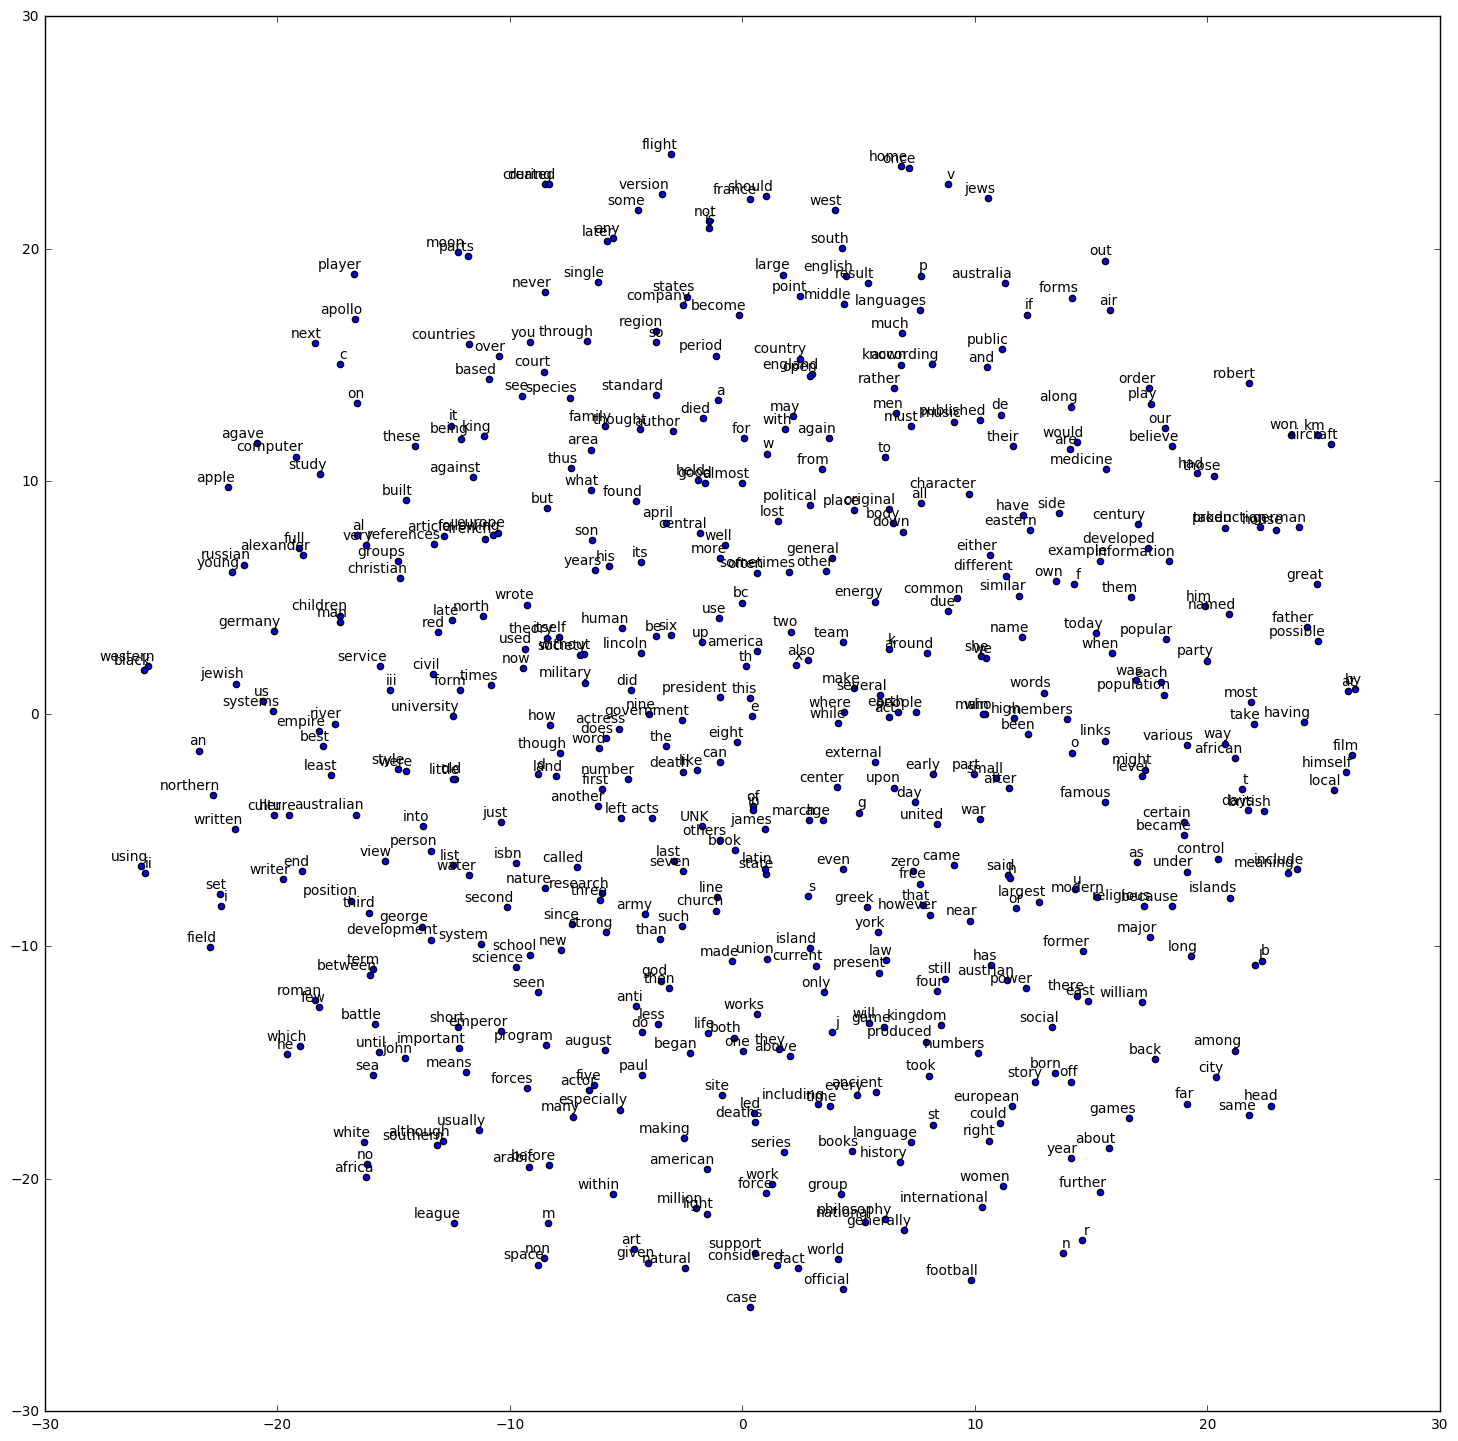

In [8]:
# Step 6: Visualize the embeddings.


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)
  plt.show()

try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")